In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 512
GAMMA = 0.99
LR = 0.0003
EPS = 1e-8

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## main

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
epsilon_decay = False
# update_frq = int(env.spec.timestep_limit/10)
update_frq = 1
# epsilon = 1.
eps_min = 0.005
# eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
# optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=LR, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

1000

In [7]:
env.spec.reward_threshold

200

In [8]:
env.spec.timestep_limit

1000

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < eps_min:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
#         epsilon -= epsilon * eps_decay
#         epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    50 steps, reward -365.41
  2 Episode in   114 steps, reward -548.22
  3 Episode in   190 steps, reward -548.29
  4 Episode in   246 steps, reward -556.05
  5 Episode in   322 steps, reward -523.63
  6 Episode in   378 steps, reward -512.56
  7 Episode in   455 steps, reward -835.45
  8 Episode in   533 steps, reward -693.98
  9 Episode in   588 steps, reward -540.21
 10 Episode in   648 steps, reward -525.83
 11 Episode in   718 steps, reward -612.44
 12 Episode in   770 steps, reward -461.45
 13 Episode in   833 steps, reward -549.06
 14 Episode in   893 steps, reward -531.40
 15 Episode in   953 steps, reward -597.42
 16 Episode in  1008 steps, reward -500.84
 17 Episode in  1084 steps, reward -821.64
 18 Episode in  1151 steps, reward -550.73
 19 Episode in  1218 steps, reward -557.22
 20 Episode in  1297 steps, reward -811.03
 21 Episode in  1360 steps, reward -646.42
 22 Episode in  1416 steps, reward -522.84
 23 Episode in  1478 steps, reward -617.94
 24 Episode

192 Episode in 92413 steps, reward -138.73
193 Episode in 93413 steps, reward -57.60
194 Episode in 94413 steps, reward -60.01
195 Episode in 95413 steps, reward -69.42
196 Episode in 95504 steps, reward -416.33
197 Episode in 95774 steps, reward -396.63
198 Episode in 96774 steps, reward -82.46
199 Episode in 97011 steps, reward -445.32
200 Episode in 98011 steps, reward -75.04
201 Episode in 99011 steps, reward -95.48
202 Episode in 100011 steps, reward -65.89
203 Episode in 100956 steps, reward -453.26
204 Episode in 101083 steps, reward -375.15
205 Episode in 102083 steps, reward -43.43
206 Episode in 102477 steps, reward 170.33
207 Episode in 102761 steps, reward -109.11
208 Episode in 103761 steps, reward -99.14
209 Episode in 104761 steps, reward -83.39
210 Episode in 105761 steps, reward -47.56
211 Episode in 106704 steps, reward 73.42
212 Episode in 107632 steps, reward 109.49
213 Episode in 108394 steps, reward 118.32
214 Episode in 108899 steps, reward -365.13
215 Episode in

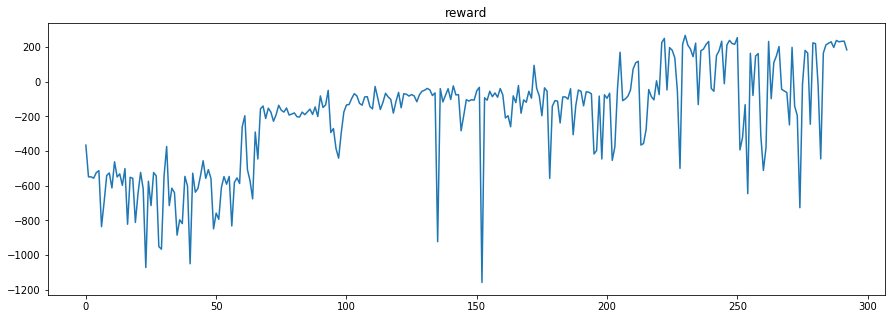

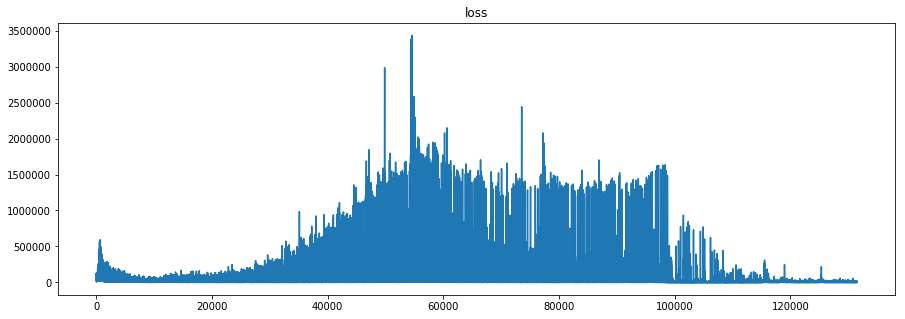

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()